## Computation of confidence intervals using a grid search
Computing confidence intervals using a grid search is a method particularly useful when analytic solutions are unavailable. By evaluating the parameter space, calculating posterior probabilities for every point, and deriving credible intervals we get a confidence interval given the data and prior knowledge such that P[Θ ∈ I | X] = 1−α where alpha is our confidence level. In this manner  it is an analogue to a frequentist confidence interval.

By first creating a fine grid of plausible values for our parameters and defining a posterior, following bayesian inference, we can compute the value of the posterior in each point. Meaning that every combination of n parameters is used to calculate the posterior giving a hypercube filled with **m_1 \cdot m_2 \cdot ... \cdot m_n** points. (for ** m_i** the total number of chosen grid values).
 

To identify the confidence interval we have two main methods. The equal tail methods consists of looking at the interval [θ(α/2),θ(1−α/2)], which determines the region where all points lay such the probability for a point to lay in this interval is 1- alpha. This reflects the true probability the value of our parameter lies in that interval. However this brings some ambiguity into play. Imagine a simple gaussian distribution. we can construct a alpa =0.5 interval on the left side going from -inf to the mean or an interval on the right side. we can also have the mean in the middle of the interval and symmetrically go to both side. To solve this ambivalence we try to minimize the length of the interval. Or let the interval be determined by equalling the excluded area on both tail-ends. rtest



## Complete example
To illustrate bayesian inference using grid searches to determine confidence intervals and updating said posterior we will look at the Intensity I_e of an galaxy at several radii. It has three parameter of which two are independent. r_e is the scale length for which the r=0 intensity has dropped to half its value,  n is the Sersic index controlling the curvature of the profile. b_n is determined by solving the eq. $$\gamma (2n,bn) = 0.5 \Gamma(2n)$$ or for n > 0.5 the approximation: $$ b(n) = 2n − \frac{1}{3} + \frac{4}{405n}  + \frac{46}{25515n^2}$$
giving the full profile the following form:
$$ \rho = \rho_0 \exp{ \left[-b_n \left( \frac{r}{r_e} \right)^{\frac{1}{n}}- 1 \right]} $$






source: https://arxiv.org/pdf/astro-ph/9911078 and https://ned.ipac.caltech.edu/level5/March05/Graham/Graham2.html






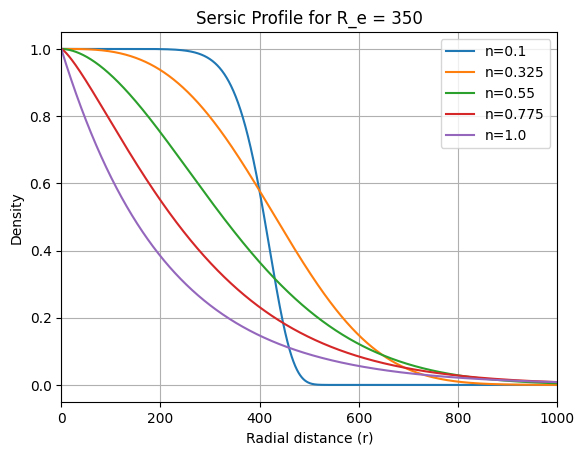

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm.notebook import tqdm
import numpy as np
import scipy.optimize as opt
import scipy.special as sp
import matplotlib.pyplot as plt

# -------------------- Step 1: Simulate SNR density distribution --------------------
np.random.seed(12122387)

def sersic_profile(r, r_e, n):
    """Compute the Sérsic profile"""
    b_n = 2 * n - 1/3 +4/(405*n) + 46/(25515*n**2) # Approximation for b_n 
    rho = np.exp(-b_n * ((r / r_e)**(1/n) - 1))
    return rho / np.max(rho) 
   
   
R_max  = 1e3
r_range = np.linspace(0,R_max,10000)

# True parameters
n = np.linspace(0.1,1, 5)
r_e = 350

plt.figure()
plt.title("Sersic Profile for R_e = 350")
for i in range(len(n)):
    plt.plot(r_range, sersic_profile(r_range, r_e, n[i]), label=f"n={n[i]}")

plt.xlim(0,R_max)
plt.grid()
plt.xlabel("Radial distance (r)")
plt.ylabel("Density")
plt.legend()

plt.show()


We will sample n points from this distribution (with n = 0.35, as an example, normall we have profiles ~1 or ~4), picking a relatively unprecise simulation first. We'll do so to show how we can improve this later by updating the posterior with a new data set. The simulated data will be given a gaussian scatter around the true value to simulate observational uncertainties. In the plot below we can see the form of this sersic profile and the simulated set. 



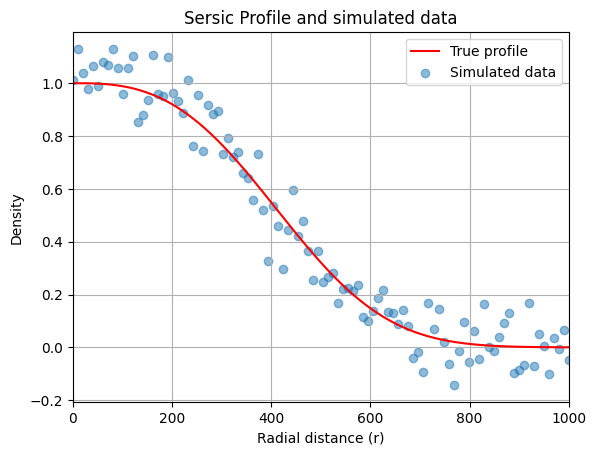

In [21]:
def sim_data(r,r_e,n, fractional_uncertainty):
	y_true = sersic_profile(r,r_e,n)
	#y_unc_true = np.abs(y_true)*
	y_sample = np.random.normal(y_true, fractional_uncertainty, size=len(r)) 
	return y_sample, fractional_uncertainty#, y_unc_true


R_max  = 1e3 
r_range_model = np.linspace(0,R_max,1000)

# True parameters
true_n = 0.35
true_r_e = 350

#simulating data
unc = 0.08
r_range_sim = np.linspace(0,R_max,100)

sim_r, sim_r_uncertainty = sim_data(r_range_sim, true_r_e , true_n, unc)
# 
plt.figure()
plt.title("Sersic Profile and simulated data")
plt.plot(r_range_model, sersic_profile(r_range_model, true_r_e, true_n), c="red", label="True profile")
plt.scatter(r_range_sim, sim_r, alpha=0.5, label="Simulated data")
plt.xlim(0,R_max)
plt.grid()
plt.xlabel("Radial distance (r)")
plt.ylabel("Density")
plt.legend()
plt.show()

After simulating the data we can start the bayesian inference. We start with choosing a prior. For now we will assume a flat prior which is around the true n and true r_e value. From looking at different simulated sersic profiles such bounds could in practise be estimated. The statistical model will be a guassian likelihood. Since we will work with calculations with small values we prefer the log-likelihood to reduce numerical problems. 

Calculating the posterior then comes down to calculating the product of the prior and likelihood (or the exponent containing the sum of the log-prior and the log-likelihood).  

In [22]:
# -------------------- Step 2: Define Prior and Likelihood --------------------
def flat_prior(n, r_e ):
    if 0.1<= n <= 0.6 and 200 <= r_e <= 500:  # Example bounds
        return 1
    return 0 

def log_likelihood(r, observed, sigma, r_e, n,):
    model_density = sersic_profile(r, r_e, n)
    return (-np.sum(0.5 * ((observed - model_density) / sigma) ** 2 + np.log(sigma * np.sqrt(2 * np.pi))))

def posterior(n_space, r_e_space, r_range, sim_r, sim_r_uncertainty, prior):
    log_posterior_grid = np.full((len(n_space),len(r_e_space)), -np.inf)
    
    # Loop over all combinations of n and r_e, filling in the grid with values of the posterior
    for i in tqdm(range(len(n_space))):
        for j in range(len(r_e_space)):
            prior_val = prior(n_space[i],r_e_space[j] )
            if prior_val == 0:
                continue
            else:
                # Compute likelihood for this position (using the simulated data)
                # Compute the posterior for this position,
                # i represents the n parameter (axis = 0), and j represents the r_e parameter (axis=1)
                log_likelihood_value = log_likelihood(r_range, sim_r, sim_r_uncertainty,r_e_space[j], n_space[i] )
                log_posterior_grid[i, j] = log_likelihood_value + np.log(prior_val)    
                
    posterior = np.exp(log_posterior_grid - np.max(log_posterior_grid))
    
    return  posterior


Using a grid forces us to calculate this posterior for every point in the grid, as explained in ... . We will first compute a coarse grid to determine the range of values without spending excess time on computing fine grids in unwanted regions.

In [23]:
# Create a "coarse" 2D grid of r_e and n,
#simulation time = 10 seconds
n_space = np.linspace(0.2, 0.6, 250)
r_e_space = np.linspace(200, 500, 250)
posterior_grid = posterior(n_space, r_e_space, r_range_sim, sim_r, sim_r_uncertainty, flat_prior)
posterior_grid /= np.sum(posterior_grid)  # Normalizing the grid 


  0%|          | 0/250 [00:00<?, ?it/s]

The best-fit parameters are determined by a point with the highest posterior value. 

In [24]:
#  best-fit parameters found by using argmax and indexing
max_idx = np.unravel_index(np.argmax(posterior_grid), posterior_grid.shape)
best_fit_n = n_space[max_idx[0]]
best_fit_r_e = r_e_space[max_idx[1]]

print(f"Best-fit n: {best_fit_n:.3f}")
print(f"Best-fit r_e: {best_fit_r_e:.3f}")  

Best-fit n: 0.337
Best-fit r_e: 344.578


To get a feeling of how the posterior distribution of both parameters looks like we will plot the following:
- A 2D posterior density
- The margenalised posterior for r_e
- The margenalised posterior for n

This gives us a feeling for how the distribution looks like, enabeling us to determine a finer grid.

Margenalising over one of the parameters is done by summing (for continious function an intergral is taken) over all other parameters, collapsing the posterior into a single-parameter function. $$ P(r_e) = \Sigma_{n} P(r_e,n) $$

We then plot all of these, along with the best fit value and the true values.


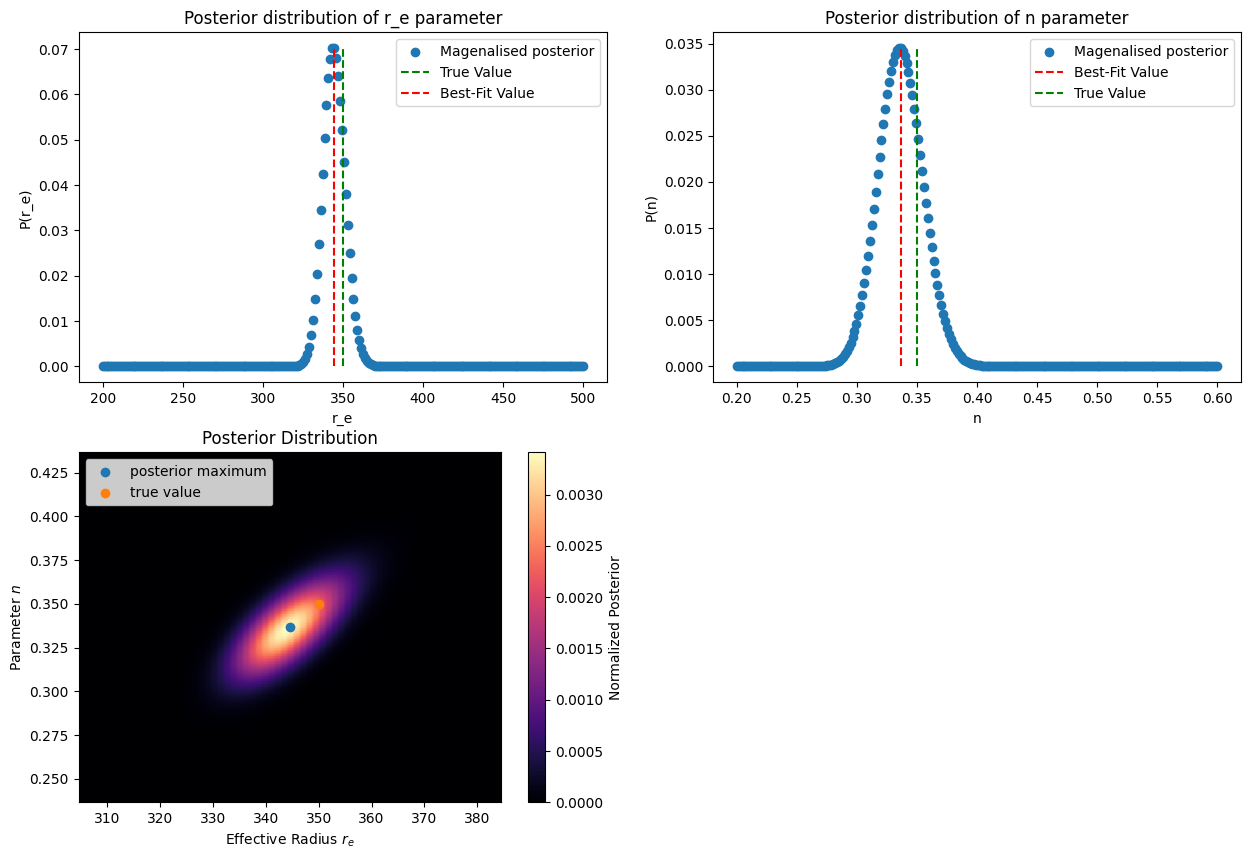

In [31]:
P_r_e = np.sum(posterior_grid, axis=0)
P_n = np.sum(posterior_grid, axis=1)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("Posterior distribution of r_e parameter")
plt.scatter(r_e_space, P_r_e, label="Magenalised posterior")
plt.vlines(true_r_e, ymin=np.min(P_r_e),ymax=np.max(P_r_e), color="g", linestyles="--", label="True Value")
plt.vlines(x= best_fit_r_e, ymin=np.min(P_r_e),ymax=np.max(P_r_e), color="r", linestyles="--", label="Best-Fit Value")
plt.xlabel("r_e")
plt.ylabel("P(r_e)")
plt.legend()

plt.subplot(2,2,2)
plt.title("Posterior distribution of n parameter")
plt.scatter(n_space,P_n,  label="Magenalised posterior")
plt.vlines(x= best_fit_n,ymin=np.min(P_n),ymax=np.max(P_n), color="r", linestyles="--", label="Best-Fit Value")
plt.vlines(true_n, ymin=np.min(P_n),ymax=np.max(P_n), color="g", linestyles="--", label="True Value")
plt.xlabel("n")
plt.ylabel("P(n)")
plt.legend()


plt.subplot(2,2,3)
plt.imshow(posterior_grid, extent=[r_e_space.min(), r_e_space.max(), n_space.min(), n_space.max()], origin='lower', aspect='auto', cmap='magma')
plt.colorbar(label="Normalized Posterior",cmap='magma' )
plt.scatter(best_fit_r_e, best_fit_n, label="posterior maximum")
plt.scatter(true_r_e,true_n, label="true value",c="cyan")

plt.title("Posterior Distribution")
plt.xlabel("Effective Radius $r_e$")
plt.ylabel("Parameter $n$")
plt.ylim(best_fit_n-0.1, best_fit_n+0.1)
plt.xlim(best_fit_r_e-40, best_fit_r_e+40)
plt.legend(loc="upper left")
plt.show()


We can see that both the margenalised posteriors have gausian-like curves relatively close to the true parameters. We can now create a smaller and finer grid to correctly determine the confidence intervals of both parameters, which we til this point have neglected. We center the grid around the best fit value and add many more points to the grid. Then in the same manner we plot the (margenalized) posterior.  

In [32]:

#defining a finer grid. Not this well take ~1min of computing time 
n_space = np.linspace(best_fit_n-0.15, best_fit_n+0.15, 2000)
r_e_space = np.linspace(best_fit_r_e-50, best_fit_r_e+50, 2000)
posterior_grid = posterior(n_space, r_e_space, r_range_sim, sim_r, sim_r_uncertainty, flat_prior)
P_r_e = np.sum(posterior_grid, axis=0)
P_n = np.sum(posterior_grid, axis=1)


  0%|          | 0/2000 [00:00<?, ?it/s]

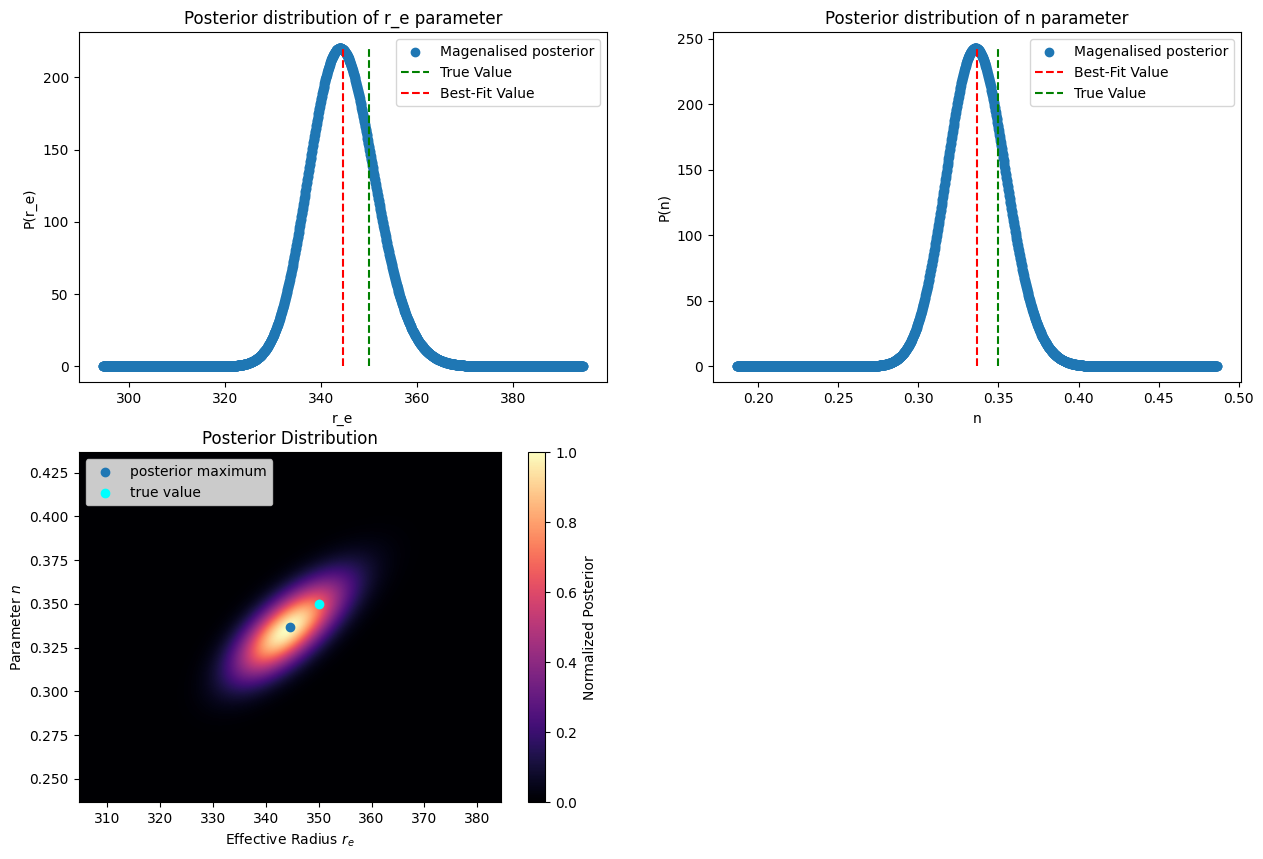

In [35]:

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("Posterior distribution of r_e parameter")
plt.scatter(r_e_space, P_r_e, label="Magenalised posterior")
plt.vlines(true_r_e, ymin=np.min(P_r_e),ymax=np.max(P_r_e), color="g", linestyles="--", label="True Value")
plt.vlines(x= best_fit_r_e, ymin=np.min(P_r_e),ymax=np.max(P_r_e), color="r", linestyles="--", label="Best-Fit Value")
plt.xlabel("r_e")
plt.ylabel("P(r_e)")
plt.legend()

plt.subplot(2,2,2)
plt.title("Posterior distribution of n parameter")
plt.scatter(n_space,P_n,  label="Magenalised posterior")
plt.vlines(x= best_fit_n,ymin=np.min(P_n),ymax=np.max(P_n), color="r", linestyles="--", label="Best-Fit Value")
plt.vlines(true_n, ymin=np.min(P_n),ymax=np.max(P_n), color="g", linestyles="--", label="True Value")
plt.xlabel("n")
plt.ylabel("P(n)")
plt.legend()


plt.subplot(2,2,3)
plt.imshow(posterior_grid, extent=[r_e_space.min(), r_e_space.max(), n_space.min(), n_space.max()], origin='lower', aspect='auto', cmap='magma')
plt.colorbar(label="Normalized Posterior",cmap='magma' )
plt.scatter(best_fit_r_e, best_fit_n, label="posterior maximum")
plt.scatter(true_r_e,true_n, label="true value", c="cyan")

plt.title("Posterior Distribution")
plt.xlabel("Effective Radius $r_e$")
plt.ylabel("Parameter $n$")
plt.ylim(best_fit_n-0.1, best_fit_n+0.1)
plt.xlim(best_fit_r_e-40, best_fit_r_e+40)
plt.legend(loc="upper left")
plt.show()

In [36]:
#  best-fit parameters
max_idx = np.unravel_index(np.argmax(posterior_grid), posterior_grid.shape)
best_fit_n = n_space[max_idx[0]]
best_fit_r_e = r_e_space[max_idx[1]]
print(f"Best-fit n: {best_fit_n:.3f}")
print(f"Best-fit r_e: {best_fit_r_e:.3f}")  


Best-fit n: 0.335
Best-fit r_e: 344.003


## confidence intervals

Up until now, everything is similar as previous example. We now also want to say something about the confidence interval around the best fit value. To do so we will compute the cumulative distribution of the posterior. This is the probability for a random variable X to take on a value less than or equal to a certain value x. The CDF can then be used to find the percentile forming the interval's bounds. These percentiles are combined with the sample statistic, enabling to define the interval in the parameter space. 

The first function will do so by looking for exactly these bounderies. It will work for most applications. In the case we have a probability distribution that has two maxima or is centered around a hard bound (lets say the number of particles which can never be 0 but a distribution that goes into the negatives), we can use the second function. It works similarly as the first function but will calculate the probability to lie within two bounds: {i,j} if this matches the desired confidence interval these bounds are saved. We then search for all ambigious points also having such valid interval and search for the one with minimum width. This will provide the wanted interval. 


In [86]:
def compute_equal_tailed_interval(parameter_space, posterior, alpha):
    cdf = np.cumsum(posterior)
    lower_bound = parameter_space[np.searchsorted(cdf, alpha / 2)]
    upper_bound = parameter_space[np.searchsorted(cdf, 1 - alpha / 2)]
    return lower_bound, upper_bound

def find_minimal_interval(parameter_space, posterior, alpha):
    # Normalize posterior to ensure it sums to 1
    posterior = posterior / np.sum(posterior)

    # Initialize variables
    min_width = np.inf
    best_interval = None
    target_prob =  1-alpha
    
    # Sliding window
    for i in tqdm(range(len(parameter_space)), desc="Parameter space"):  # Start of the window
        cumulative_prob = 0  # Reset cumulative probability for each new starting point
        
        for j in range(i, len(parameter_space)):  # End of the window
            # Expand the window by adding the probability at j
            cumulative_prob += posterior[j]

            # Check if the window meets or exceeds the target probability
            if cumulative_prob >= target_prob:
                # Calculate the width of the current window
                width = parameter_space[j] - parameter_space[i]

                # If the current window's width is smaller, update the best interval
                if width < min_width:
                    min_width = width
                    best_interval = (round(parameter_space[i], 3), round(parameter_space[j], 3))

                # No need to continue further as we want to minimize the width
                break  # Move to the next starting point (i)

    return best_interval

In [87]:
P_r_e = np.sum(posterior_grid, axis=0)
P_n = np.sum(posterior_grid, axis=1)


# Normalize the marginalized distributions
n_mag = P_n /  np.sum(P_n)
r_e_mag = P_r_e /  np.sum(P_r_e)

# Compute confidence intervals (# 95% confidence)
alpha = 0.16
n_lower, n_upper = compute_equal_tailed_interval(n_space, n_mag, alpha)
r_e_lower, r_e_upper = compute_equal_tailed_interval(r_e_space, r_e_mag, alpha)

# Find minimal-width intervals for n and r_e
n_min_interval = find_minimal_interval(n_space, n_mag, alpha)
r_e_min_interval = find_minimal_interval(r_e_space, r_e_mag, alpha)


Parameter space:   0%|          | 0/2000 [00:00<?, ?it/s]

Parameter space:   0%|          | 0/2000 [00:00<?, ?it/s]

confidence interval for n: [0.332 - 0.385]
confidence interval for r_e: [343.832 - 364.093]


Minimal-width interval for n confidence: [0.331 - 0.384] 
Minimal-width interval for r_e confidence:[343.232 - 363.442]


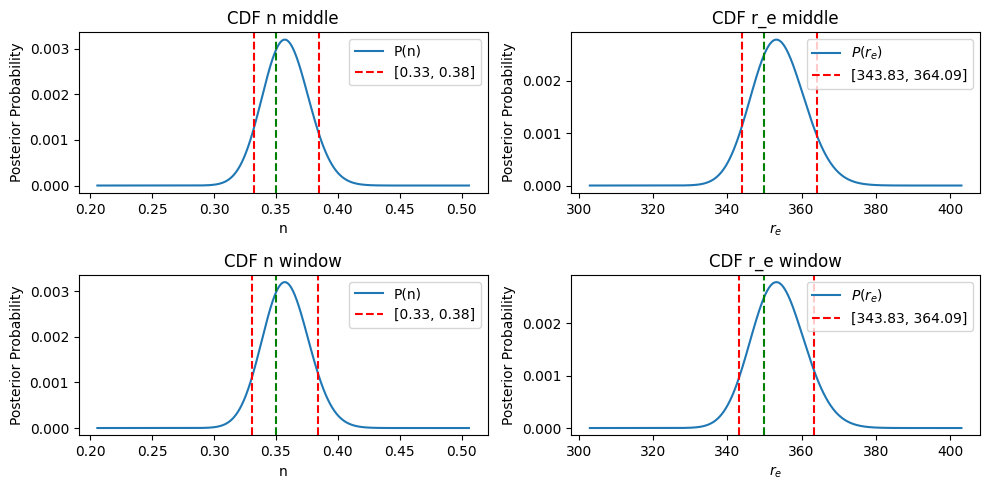

In [88]:
print(f"confidence interval for n: [{n_lower:.3f} - {n_upper:.3f}]")
print(f"confidence interval for r_e: [{r_e_lower:.3f} - {r_e_upper:.3f}]")
print("\n")
print(f"Minimal-width interval for n confidence: [{n_min_interval[0]} - {n_min_interval[1]}] ")
print(f"Minimal-width interval for r_e confidence:[{r_e_min_interval[0]} - {r_e_min_interval[1]}]")

plt.figure(figsize=(10, 5))

# Marginalized n
plt.subplot(2, 2, 1)
plt.plot(n_space, n_mag, label='P(n)')
plt.title("CDF n middle")
plt.axvline(n_lower, color='r', linestyle='--', label=f"[{n_lower:.2f}, {n_upper:.2f}]")
plt.axvline(n_upper, color='r', linestyle='--')
plt.axvline(true_n, color='green', linestyle='--')

plt.xlabel("n")
plt.ylabel("Posterior Probability")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(n_space, n_mag, label='P(n)')
plt.title("CDF n window")
plt.axvline(n_min_interval[0], color='r', linestyle='--', label=f"[{n_lower:.2f}, {n_upper:.2f}]")
plt.axvline(n_min_interval[1], color='r', linestyle='--')
plt.axvline(true_n, color='green', linestyle='--')

plt.xlabel("n")
plt.ylabel("Posterior Probability")
plt.legend()

# Marginalized r_e
plt.subplot(2, 2, 2)
plt.title("CDF r_e middle")
plt.plot(r_e_space, r_e_mag, label=r'$P(r_e)$')
plt.axvline(r_e_lower, color='r', linestyle='--', label=f"[{r_e_lower:.2f}, {r_e_upper:.2f}]")
plt.axvline(r_e_upper, color='r', linestyle='--')
plt.axvline(true_r_e, color='green', linestyle='--')

plt.xlabel(r"$r_e$")
plt.ylabel("Posterior Probability")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("CDF r_e window")
plt.plot(r_e_space, r_e_mag, label=r'$P(r_e)$')
plt.axvline(r_e_min_interval[0], color='r', linestyle='--', label=f"[{r_e_lower:.2f}, {r_e_upper:.2f}]")
plt.axvline(r_e_min_interval[1], color='r', linestyle='--')
plt.axvline(true_r_e, color='green', linestyle='--')

plt.xlabel(r"$r_e$")
plt.ylabel("Posterior Probability")
plt.legend()

plt.tight_layout()
plt.show()  

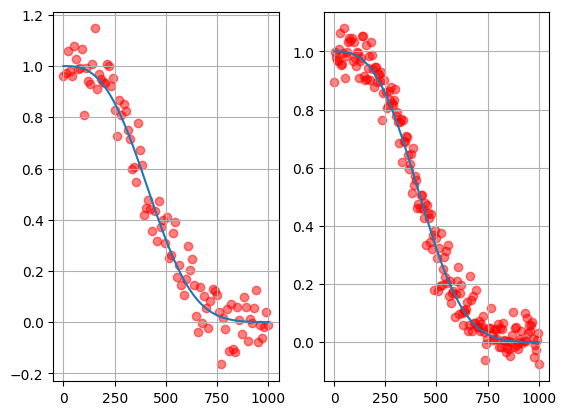

In [99]:
unc_better = 0.05
r_range_better = np.linspace(0,R_max,200)

sim_r_2, sim_r_uncertainty_2 = sim_data(r_range_better, true_r_e, true_n, unc_better)

plt.figure()
plt.subplot(1,2,1)
plt.plot(r_range_model, sersic_profile(r_range_model, true_r_e, true_n))
plt.scatter(r_range_sim, sim_r, alpha=0.5, c="red")

plt.grid()

plt.subplot(1,2,2)
plt.plot(r_range_model, sersic_profile(r_range_model, true_r_e, true_n))
plt.scatter(r_range_better, sim_r_2, alpha=0.5, c="red")

plt.grid()
plt.show()


In [100]:
posterior_grid_2 = posterior(n_space, r_e_space, r_range_better, sim_r_2, sim_r_uncertainty_2, flat_prior)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [101]:
posterior_grid_2 /= np.sum(posterior_grid_2) 

posterior_grid_updated = posterior_grid_2 * posterior_grid
posterior_grid_updated /= np.sum(posterior_grid_updated)

#  best-fit parameters
max_idx = np.unravel_index(np.argmax(posterior_grid_2), posterior_grid_2.shape)
best_fit_n_2 = n_space[max_idx[0]]
best_fit_r_e_2 = r_e_space[max_idx[1]]

print(f"Best-fit n: {best_fit_n_2:.3f}")
print(f"Best-fit r_e: {best_fit_r_e_2:.3f}") 

max_idx = np.unravel_index(np.argmax(posterior_grid_updated), posterior_grid_updated.shape)
best_fit_n_updated = n_space[max_idx[0]]
best_fit_r_e_updated = r_e_space[max_idx[1]]
print('\n')
print(f"Best-fit n with update: {best_fit_n_updated:.3f}")
print(f"Best-fit r_e with update: {best_fit_r_e_updated:.3f}") 

Best-fit n: 0.351
Best-fit r_e: 352.437


Best-fit n with update: 0.352
Best-fit r_e with update: 352.637


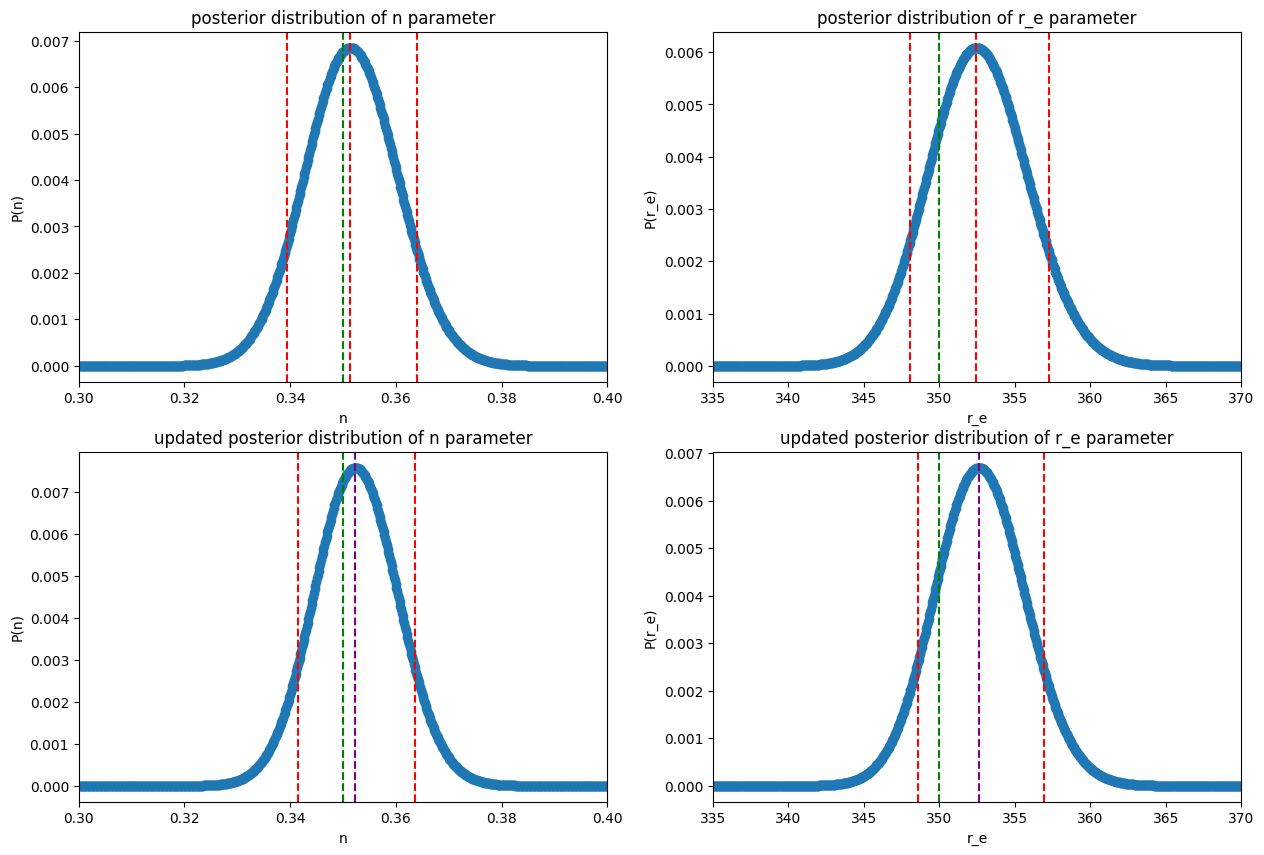

In [102]:
P_r_e_2 = np.sum(posterior_grid_2, axis=0)
r_e_mag_2 = P_r_e_2 / np.sum(P_r_e_2)
P_n_2 = np.sum(posterior_grid_2, axis=1)
n_mag_2 = P_n_2 / np.sum(P_n_2)


P_r_e_updated = np.sum(posterior_grid_updated, axis=0)
r_e_mag_updated = P_r_e_updated / np.sum(P_r_e_updated)
P_n_updated = np.sum(posterior_grid_updated, axis=1)
n_mag_updated = P_n_updated / np.sum(P_n_updated)


alpha = 0.16
# Compute confidence intervals 
n_lower_2, n_upper_2 = compute_equal_tailed_interval(n_space, n_mag_2, alpha)
r_e_lower_2, r_e_upper_2 = compute_equal_tailed_interval(r_e_space, r_e_mag_2, alpha)

n_lower_updated, n_upper_updated = compute_equal_tailed_interval(n_space, n_mag_updated, alpha)
r_e_lower_updated, r_e_upper_updated = compute_equal_tailed_interval(r_e_space, r_e_mag_updated, alpha)


plt.figure(figsize=(15,10))
plt.subplot(2,2,2)
plt.title("posterior distribution of r_e parameter")
plt.scatter(r_e_space, P_r_e_2)
plt.axvline(r_e_lower_2, color='r', linestyle='--')
plt.axvline(r_e_upper_2, color='r', linestyle='--')
plt.axvline(best_fit_r_e_2, color="r", linestyle="--")
plt.axvline(true_r_e, color='green', linestyle='--')
plt.xlabel("r_e")
plt.ylabel("P(r_e)")
plt.xlim(335, 370)


plt.subplot(2,2,1)
plt.title("posterior distribution of n parameter")
plt.scatter(n_space,P_n_2)
plt.axvline(n_lower_2, color='r', linestyle='--')
plt.axvline(n_upper_2, color='r', linestyle='--')
plt.axvline(best_fit_n_2, color="r", linestyle="--")

plt.axvline(true_n, color='green', linestyle='--')

plt.xlabel("n")
plt.ylabel("P(n)")
plt.xlim(0.3, 0.4)

plt.subplot(2,2,4)
plt.title("updated posterior distribution of r_e parameter")
plt.scatter(r_e_space, P_r_e_updated)
plt.axvline(r_e_lower_updated, color='r', linestyle='--')
plt.axvline(r_e_upper_updated, color='r', linestyle='--')
plt.axvline(x= best_fit_r_e_updated, color="purple", linestyle="--")
plt.axvline(true_r_e, color='green', linestyle='--')
plt.xlabel("r_e")
plt.ylabel("P(r_e)")
plt.xlim(335, 370)


plt.subplot(2,2,3)
plt.title("updated posterior distribution of n parameter")
plt.scatter(n_space,P_n_updated)
plt.axvline(n_lower_updated, color='r', linestyle='--')
plt.axvline(n_upper_updated, color='r', linestyle='--')
plt.axvline(x= best_fit_n_updated, color="purple", linestyle="--")
plt.axvline(true_n, color='green', linestyle='--')

plt.xlabel("n")
plt.ylabel("P(n)")
plt.xlim(0.3, 0.4)
plt.show()

In [103]:
print(f"confidence interval for n: [{n_lower_2:.3f}, {n_upper_2:.3f}]")
print(f"confidence interval for r_e: [{r_e_lower_2:.3f}, {r_e_upper_2:.3f}]")
print("\n")
print(f"confidence interval for n (with update): [{n_lower_updated:.3f}, {n_upper_updated:.3f}]")
print(f"confidence interval for r_e (with update): [{r_e_lower_updated:.3f}, {r_e_upper_updated:.3f}]")


confidence interval for n: [0.339, 0.364]
confidence interval for r_e: [348.035, 357.239]


confidence interval for n (with update): [0.341, 0.364]
confidence interval for r_e (with update): [348.585, 356.939]
